# Peer-graded Assignment: Course Project 

- In this project, I use data from kaggle.com to study the heart disease :https://www.kaggle.com/datasets/dileep070/heart-disease-prediction-using-logistic-regression

this data contain the following:
1. male
1. age
1. education
1. currentSmoker
1. cigsPerDay
1. BPMeds
1. prevalentStroke
1. prevalentHyp
1. diabetes
1. totChol
1. sysBP
1. diaBP
1. BMI
1. heartRate
1. glucose	

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline  

In [2]:
df = pd.read_csv('framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [3]:
df.isnull().any()

male               False
age                False
education           True
currentSmoker      False
cigsPerDay          True
BPMeds              True
prevalentStroke    False
prevalentHyp       False
diabetes           False
totChol             True
sysBP              False
diaBP              False
BMI                 True
heartRate           True
glucose             True
TenYearCHD         False
dtype: bool

In [4]:
print('Dataframe describtion:\n',df.describe())

Dataframe describtion:
               male          age    education  currentSmoker   cigsPerDay  \
count  4238.000000  4238.000000  4133.000000    4238.000000  4209.000000   
mean      0.429212    49.584946     1.978950       0.494101     9.003089   
std       0.495022     8.572160     1.019791       0.500024    11.920094   
min       0.000000    32.000000     1.000000       0.000000     0.000000   
25%       0.000000    42.000000     1.000000       0.000000     0.000000   
50%       0.000000    49.000000     2.000000       0.000000     0.000000   
75%       1.000000    56.000000     3.000000       1.000000    20.000000   
max       1.000000    70.000000     4.000000       1.000000    70.000000   

            BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count  4185.000000      4238.000000   4238.000000  4238.000000  4188.000000   
mean      0.029630         0.005899      0.310524     0.025720   236.721585   
std       0.169584         0.076587      0.462763     

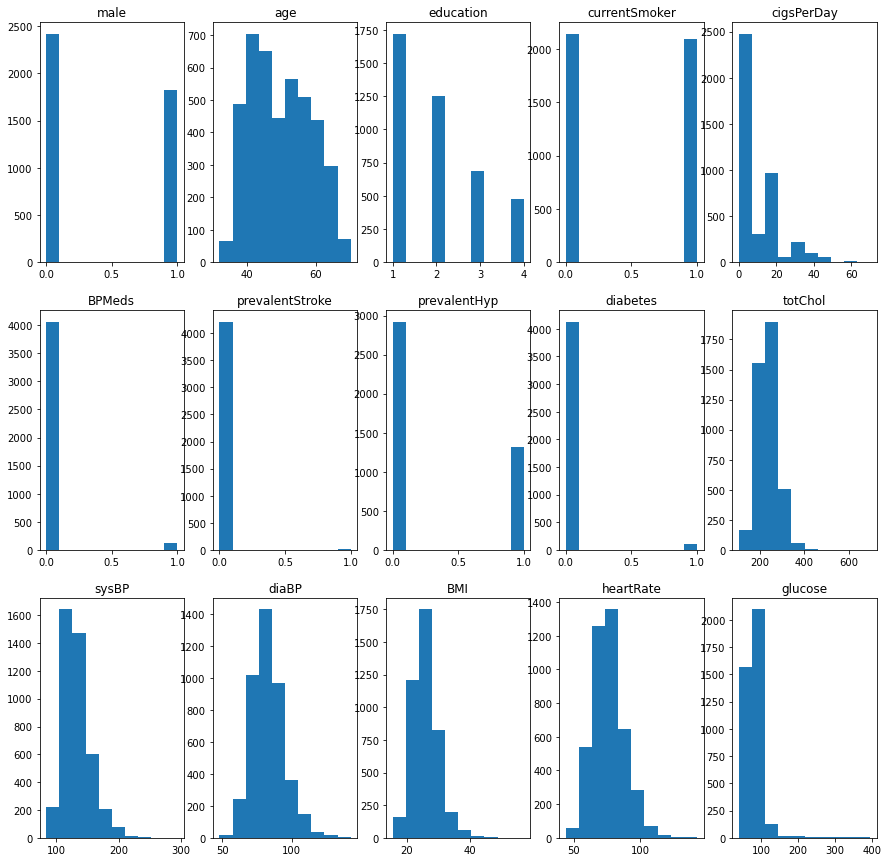

In [5]:
fig, ax = plt.subplots(3,5,figsize=(15, 15))
df1 = df.drop('TenYearCHD',axis=1)
a = df1.columns
a = np.asarray(a)
a = a.reshape(3,5)
for i in range (3):
    for j in range(5):
        ax[i,j].hist(df[a[i,j]])
        ax[i,j].set_title(a[i,j])

- Due to most of the data are encoded to fill the NAN value I used the forwerd fill method.
- The countiues features were also filled after reading the data describtion and observe the histogram of each feature, as turns out there are no outliners. 

In [6]:
df.drop(['education','BPMeds','prevalentStroke','diabetes'],axis=1,inplace=True)
df = df.fillna(method='ffill')

In [7]:
y = df.TenYearCHD
x = df.drop('TenYearCHD',axis=1)

In [8]:
print(y.shape)
print(x.shape)

(4238,)
(4238, 11)


# building the model: 
For classification  first I will build a normail logictic model and study the results.


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)


In [11]:
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0]], 
                                 codes=[[0], [0]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

,lr,l1,l2
,0,0,0
6,0.017895,0.018130,0.018024
1,0.049084,0.061516,0.061335
3,0.015446,0.015556,0.015170
8,-0.021389,-0.003232,-0.003502
7,-0.014310,-0.005111,-0.005210
10,0.006589,0.007524,0.007501
4,0.380903,0.137111,0.144322
2,-0.055169,0.021709,0.033194
5,-0.000030,0.001151,0.001120


<AxesSubplot:>

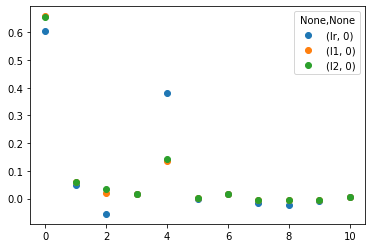

In [12]:
#data = coefficients.xs(loc, level=1, axis=1)
coefficients.plot(marker='o', ls='')

In [13]:
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [14]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1]),
              label_binarize(y_pred[lab], classes=[0,1]), 
              average='weighted')
    
    # Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

In [15]:
print(metrics)

                 lr        l1        l2
precision  0.821592  0.823000  0.819658
recall     0.850608  0.851322  0.850608
fscore     0.792638  0.795316  0.793772
accuracy   0.850608  0.851322  0.850608
auc        0.523169  0.527420  0.525084


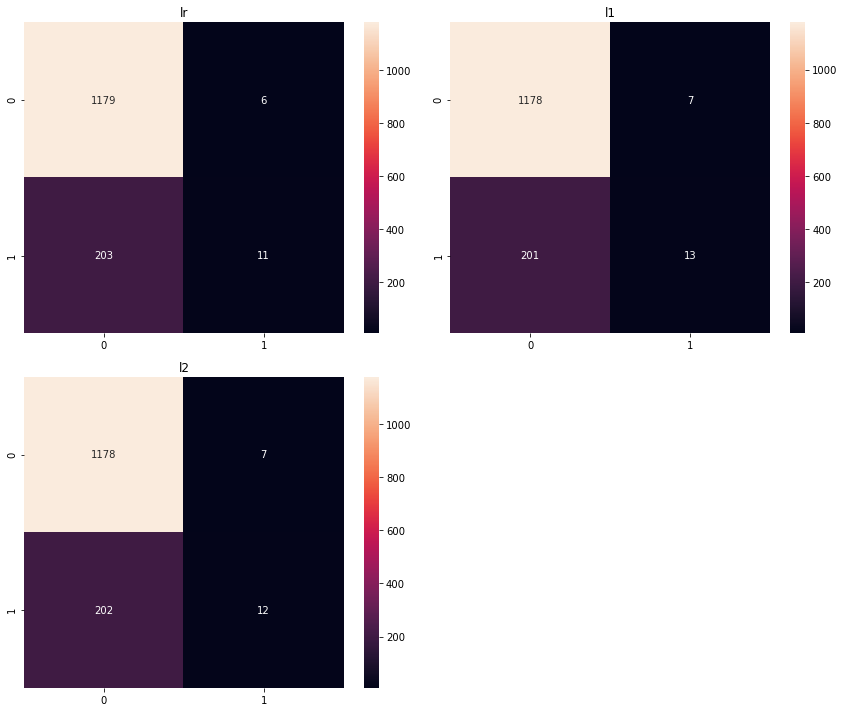

In [16]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

As reading the results we found that LogisticRegression_l1 has the better predection eaven though the numbers were close, we have to try deffernt methods and models to pick the best one 

# KNN model 

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [18]:
max_k = 50
f1_scores = list()
error_rates = list() # 1-accuracy

for k in range(1, max_k):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn = knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_pred, y_test)
    f1_scores.append((k, round(f1_score(y_test, y_pred), 4)))
    error = 1-round(accuracy_score(y_test, y_pred), 4)
    error_rates.append((k, error))
    
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
error_results = pd.DataFrame(error_rates, columns=['K', 'Error Rate'])

<Figure size 1800x1200 with 0 Axes>

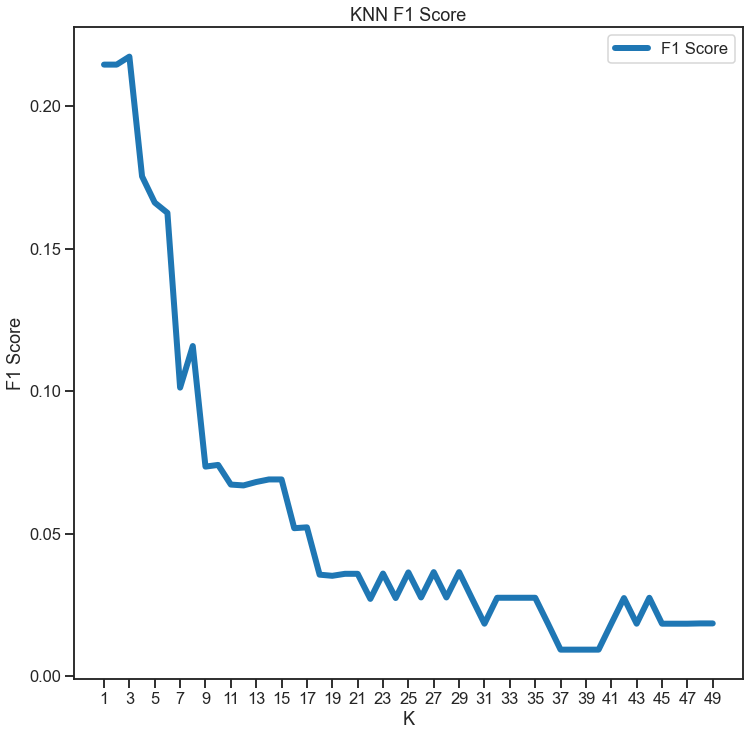

In [19]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = f1_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.title('KNN F1 Score')
plt.savefig('knn_f1.png')

<Figure size 1800x1200 with 0 Axes>

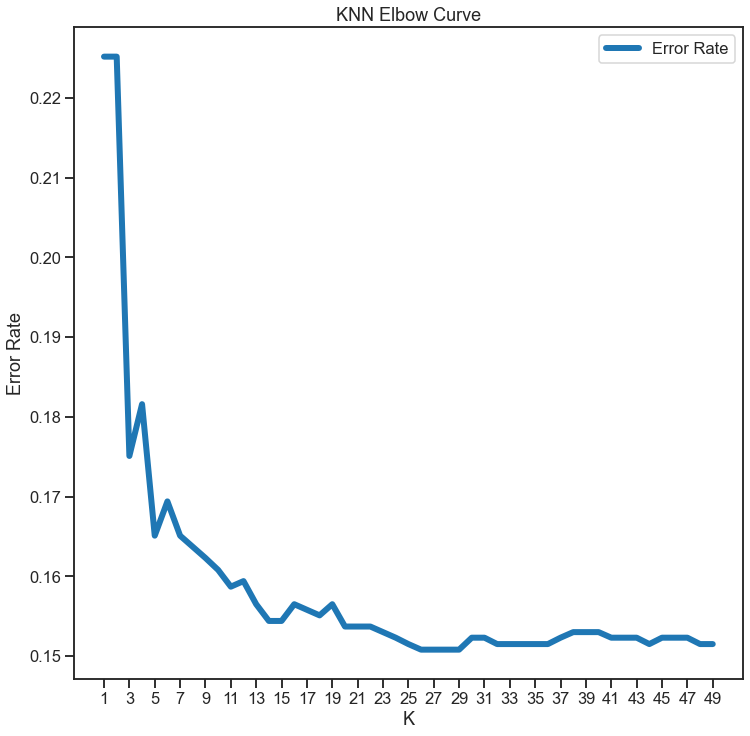

In [20]:
sns.set_context('talk')
sns.set_style('ticks')

plt.figure(dpi=300)
ax = error_results.set_index('K').plot(figsize=(12, 12), linewidth=6)
ax.set(xlabel='K', ylabel='Error Rate')
ax.set_xticks(range(1, max_k, 2))
plt.title('KNN Elbow Curve')
plt.savefig('knn_elbow.png')

by reading the previous results the Kmean model is not suitable because the F1 score is to low  

# Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)

In [22]:
dt.tree_.node_count, dt.tree_.max_depth

(873, 24)

A function to return error metrics.

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

In [24]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

train_test_full_error = pd.concat([measure_error(y_train, y_train_pred, 'train'),
                              measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

,train,test
accuracy,1.0,0.742673
precision,1.0,0.190678
recall,1.0,0.210280
f1,1.0,0.200000


By building a normal Decision Tree we receive a overfitting therefor I will use a Grid Search to find the best estimator

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

In [26]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(15, 3)

In [27]:
y_train_pred_gr = GR.predict(X_train)
y_test_pred_gr = GR.predict(X_test)

train_test_gr_error = pd.concat([measure_error(y_train, y_train_pred_gr, 'train'),
                                 measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)
train_test_gr_error

,train,test
accuracy,0.854878,0.842030
precision,0.875000,0.230769
recall,0.048837,0.014019
f1,0.092511,0.026432


the finall results show that Decision Tree can not be use on this data due to low precision and f1 scores. 

# RandomForest

In [28]:
from sklearn.ensemble import RandomForestClassifier

 
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

 
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    RF.set_params(n_estimators=n_trees)

    RF.fit(X_train, y_train)

    oob_error = 1 - RF.oob_score_
    
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

C:\Users\khaled\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\khaled\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


,oob
n_trees,
15.0,0.169778
20.0,0.167665
30.0,0.158154
40.0,0.153575
50.0,0.150757
100.0,0.150757
150.0,0.149701
200.0,0.149348
300.0,0.150757


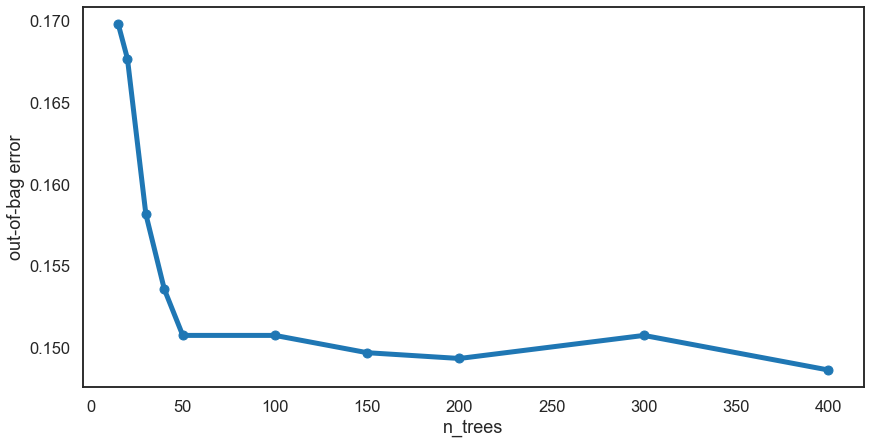

In [29]:
sns.set_context('talk')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

 
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

 
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]:
    
    EF.set_params(n_estimators=n_trees)
    EF.fit(X_train, y_train)

    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

C:\Users\khaled\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\khaled\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


,oob
n_trees,
15.0,0.166960
20.0,0.158154
30.0,0.155689
40.0,0.151814
50.0,0.148996
100.0,0.147235
150.0,0.146530
200.0,0.144417
300.0,0.145826


In [31]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

oob_df

,RandomForest,ExtraTrees
n_trees,,
15.0,0.169778,0.166960
20.0,0.167665,0.158154
30.0,0.158154,0.155689
40.0,0.153575,0.151814
50.0,0.150757,0.148996
100.0,0.150757,0.147235
150.0,0.149701,0.146530
200.0,0.149348,0.144417
300.0,0.150757,0.145826


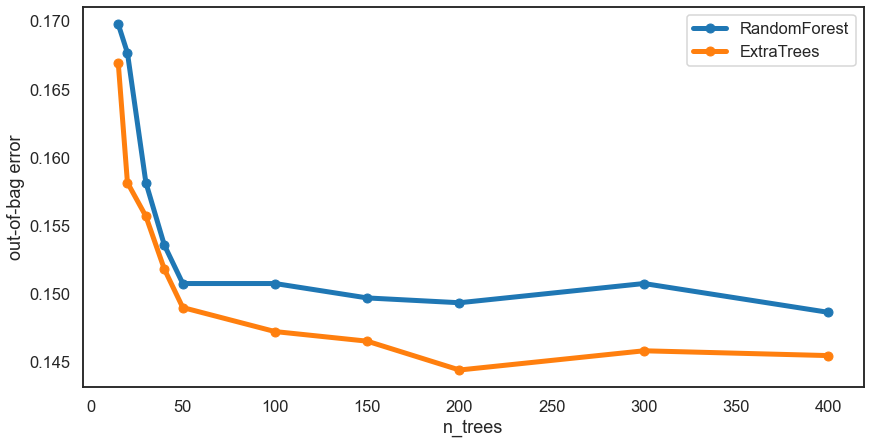

In [32]:
sns.set_context('talk')
sns.set_style('white')

ax = oob_df.plot(marker='o', figsize=(14, 7), linewidth=5)
ax.set(ylabel='out-of-bag error');

In [33]:
model = RF.set_params(n_estimators=100)

y_pred = model.predict(X_test)

In [34]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

cr = classification_report(y_test, y_pred)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=pd.Index([0]))

print(score_df)

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1185
           1       0.37      0.07      0.11       214

    accuracy                           0.84      1399
   macro avg       0.61      0.52      0.51      1399
weighted avg       0.78      0.84      0.79      1399

   accuracy  precision    recall        f1       auc
0  0.839886   0.368421  0.065421  0.111111  0.522584


### The results :
1. All KNN , Decision Tree and random Forest shows low F1 and recall scores.
1. logictic classification give us the best results.
1. One of the down side is the unbalance of our dataset.
1. the large number of our features are one of the reason of overfitting (complexity).